In [2]:
from src import kernel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Read data

In [3]:
df = pd.read_csv('./src/kernel/data/test_data1.csv')
df.head()

,0,1
0,-3.620286,-2.358816
1,-0.132184,-3.247832
2,-2.912721,-1.521750
3,-5.144268,4.760700
4,-5.693922,-2.663462


Compute kernelMean

In [4]:
kM = kernel.Mean(df,sigma='silverman')

Plot kernelMean

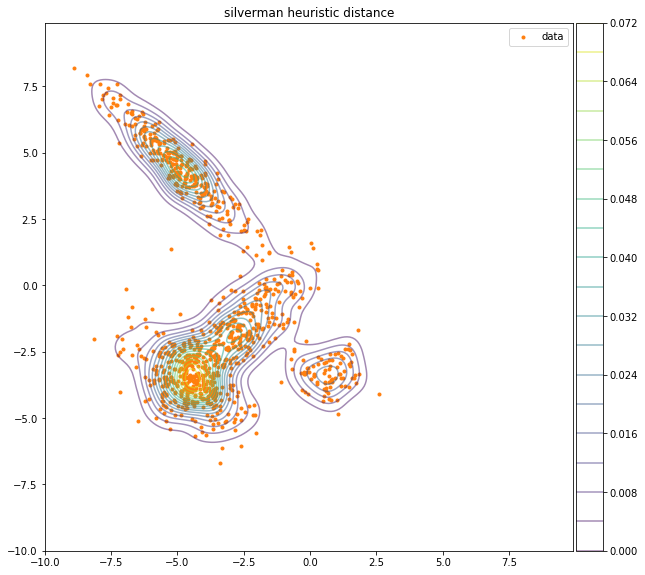

In [5]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)
z = kM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
zz = z.reshape(xx.shape[0],-1)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
bar = ax.contour(xx,yy,zz,20,alpha=0.5)
ax.scatter(df.iloc[:,0],df.iloc[:,1],alpha=1,marker='.',color='C1',label='data')
ax.set_title('silverman heuristic distance')

ax.legend()
ax.axis("image") 
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
cbar = fig.colorbar(bar,cax=cax)
fig.show()

# KernelHerding

In [6]:
KH = kernel.Herding(kM)

In [7]:
for attr in dir(KH):
    if callable(getattr(KH, str(attr))):
        print(attr)

__class__
__delattr__
__dir__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
_argmax
_herding_update
_kernel_gradient_from_samples
_optimizer_TPE
_optimizer_scipy
approximation_mean
kernel
supersample


### Herding w/ powell (need not be differentiable, and no derivatives are taken.)

In [47]:
supersample_powell_list = []
for i in range(10):
    supersample_powell = KH.supersample(
        sample_size=100, 
        optimizer='scipy_optim', 
        method='powell')
    supersample_powell_list.append(supersample_powell)

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:04'

In [38]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)

herding_z = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
herding_z = herding_z.reshape(xx.shape[0],-1)

original_z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
original_z = original_z.reshape(xx.shape[0],-1)

original_samples = KH.KM.x.copy()

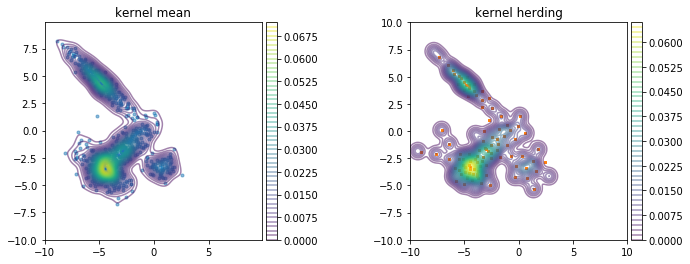

In [48]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
ax1.set_title('kernel mean')
cbar1 = ax1.contour(xx,yy,original_z,50,alpha=0.5)
ax1.scatter(original_samples.iloc[:,0], original_samples.iloc[:,1] ,alpha=0.5,marker='.')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,herding_z,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',s=8,color='C1')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax2 = divider.new_horizontal(size="5%", pad=0.05)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.add_axes(cax2)
fig.colorbar(cbar2,cax=cax2)
fig.show()

In [51]:
list_super = []
list_iid = []
for j in range(10):
    err_powell = np.zeros(len(KH.samples))
    iid_samples = original_samples.values[np.random.choice(len(original_samples),len(KH.samples)),:]
    iid_err = np.zeros(len(KH.samples))
    for i in range(1,len(KH.samples)):
        err_powell[i]= np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(supersample_powell_list[j][0:i+1, :], axis=0)/(i+1))
        iid_err[i] = np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(iid_samples[0:i+1,:], axis=0)/(i+1))
    list_super.append(err_powell)
    list_iid.append(iid_err)

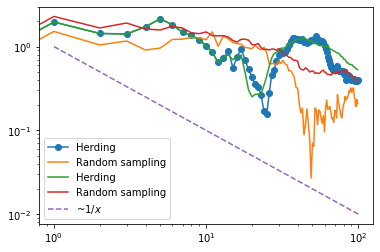

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(err_powell,'-o', label='Herding')
ax.plot(iid_err, label='Random sampling')
ax.plot(np.mean(list_super,axis=0),'-', label='Herding')
ax.plot(np.mean(list_iid,axis=0), label='Random sampling')
ax.plot([1,len(KH.samples)],[1,1./len(KH.samples)],'--', label=r'~$1/x$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
fig.show()

### Herding w/ CG (need be differentiable, and  derivatives are taken.)

In [16]:
supersample_cg = KH.supersample(
    sample_size=100, 
    optimizer='scipy_optim', 
    method='CG',
    derivatives = True)

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:12'

In [17]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)

herding_z = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
herding_z = herding_z.reshape(xx.shape[0],-1)

original_z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
original_z = original_z.reshape(xx.shape[0],-1)

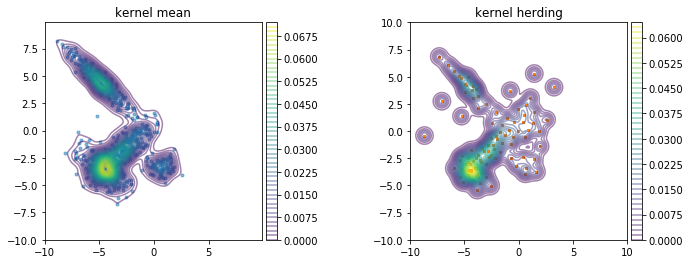

In [18]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
ax1.set_title('kernel mean')
cbar1 = ax1.contour(xx,yy,original_z,50,alpha=0.5)
ax1.scatter(original_samples.iloc[:,0], original_samples.iloc[:,1] ,alpha=0.5,marker='.')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,herding_z,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',s=8,color='C1')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax2 = divider.new_horizontal(size="5%", pad=0.05)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.add_axes(cax2)
fig.colorbar(cbar2,cax=cax2)
fig.show()

In [19]:
err_cg = np.zeros(len(KH.samples))
iid_samples = original_samples.values[np.random.choice(len(original_samples),len(KH.samples)),:]
iid_err = np.zeros(len(KH.samples))
for i in range(1,len(KH.samples)):
    err_cg[i]= np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(KH.samples[0:i+1, :], axis=0)/(i+1))
    iid_err[i] = np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(iid_samples[0:i+1,:], axis=0)/(i+1))

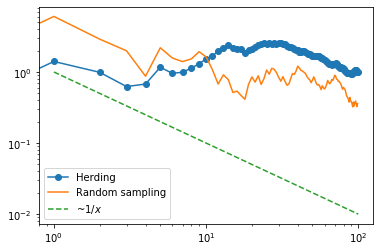

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(err_cg,'-o', label='Herding')
ax.plot(iid_err, label='Random sampling')
ax.plot([1,len(KH.samples)],[1,1./len(KH.samples)],'--', label=r'~$1/x$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
fig.show()

### Herding w/ slsqp w/ constrain w/  derivatives  (need be differentiable, and  derivatives are taken.)

In [24]:
# Use the Constrain option when you know the relationship between variables. 
cons = ({'type': 'ineq',
         'fun' : lambda x: (-x[0]**2 - x[1]**2 + 8**2),
         'jac' : lambda x: np.array([-2*x[0],-2*x[1]])})

supersample_slsqp = KH.supersample(
    sample_size=100, 
    optimizer='scipy_optim', 
    method='slsqp',
    constraints=cons, derivatives=True)

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:02'

In [25]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)

herding_z = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
herding_z = herding_z.reshape(xx.shape[0],-1)

original_z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
original_z = original_z.reshape(xx.shape[0],-1)

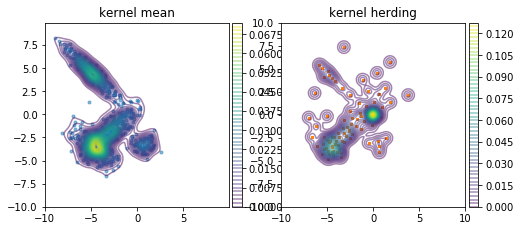

In [26]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(131)
ax1.set_title('kernel mean')
cbar1 = ax1.contour(xx,yy,original_z,50,alpha=0.5)
ax1.scatter(original_samples.iloc[:,0], original_samples.iloc[:,1] ,alpha=0.5,marker='.')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(132)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,herding_z,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',s=8,color='C1')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax2 = divider.new_horizontal(size="5%", pad=0.05)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.add_axes(cax2)
fig.colorbar(cbar2,cax=cax2)

fig.show()

In [20]:
err_slsqp_w_cons = np.zeros(len(KH.samples))
iid_samples = original_samples.values[np.random.choice(len(original_samples),len(KH.samples)),:]
iid_err = np.zeros(len(KH.samples))
for i in range(1,len(KH.samples)):
    err_slsqp_w_cons[i]= np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(KH.samples[0:i+1, :], axis=0)/(i+1))
    iid_err[i] = np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(iid_samples[0:i+1,:], axis=0)/(i+1))

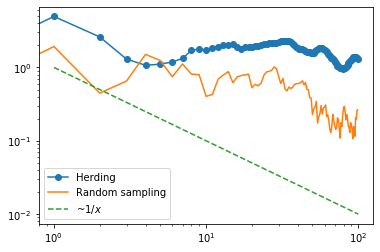

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(err_slsqp_w_cons,'-o', label='Herding')
ax.plot(iid_err, label='Random sampling')
ax.plot([1,len(KH.samples)],[1,1./len(KH.samples)],'--', label=r'~$1/x$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
fig.show()

### Herding w/ TPE

In [22]:
supersample_TPE = KH.supersample(100, optimizer='optuna', n_trials = 50)

'    100% |################################| 0day  0:00:00 Total time: 0day  0:04:38'

In [23]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)

herding_z = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
herding_z = herding_z.reshape(xx.shape[0],-1)

original_z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
original_z = original_z.reshape(xx.shape[0],-1)

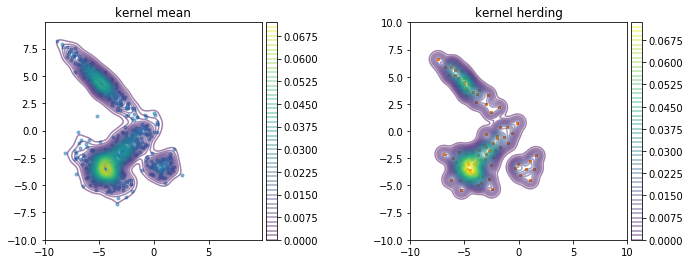

In [24]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
ax1.set_title('kernel mean')
cbar1 = ax1.contour(xx,yy,original_z,50,alpha=0.5)
ax1.scatter(original_samples.iloc[:,0], original_samples.iloc[:,1] ,alpha=0.5,marker='.')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,herding_z,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',s=8,color='C1')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax2 = divider.new_horizontal(size="5%", pad=0.05)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.add_axes(cax2)
fig.colorbar(cbar2,cax=cax2)
fig.show()

In [25]:
err_tpe = np.zeros(len(KH.samples))
for i in range(len(KH.samples)):
    err_tpe[i]= np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(KH.samples[0:i+1, :], axis=0)/(i+1))
    
list_err = []
for i in range(100):
    iid_samples = original_samples.values[np.random.choice(len(original_samples),len(KH.samples)),:]
    iid_err = np.zeros(len(KH.samples))
    for i in range(len(KH.samples)):
        iid_err[i] = np.linalg.norm(np.mean(original_samples, axis=0) - np.sum(iid_samples[0:i+1,:], axis=0)/(i+1))
    list_err.append(iid_err)

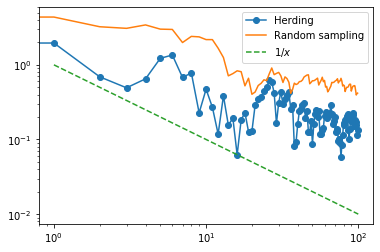

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(err_tpe,'-o', label='Herding')
ax.plot(iid_err, label='Random sampling')
ax.plot([1,len(KH.samples)],[1,1./len(KH.samples)],'--', label=r'$1/x$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
fig.show()

総括

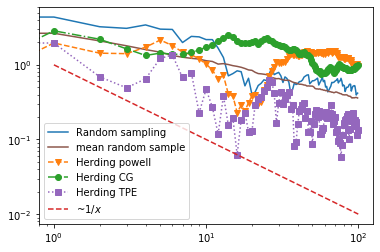

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(iid_err, label='Random sampling',color='C0')
ax.plot(np.array(list_err).mean(axis=0),label='mean random sample',color='C5')
ax.plot(err_powell,'--v', label='Herding powell',color='C1')
ax.plot(err_cg,'-.o', label='Herding CG',color='C2')
ax.plot(err_tpe,':s', label='Herding TPE',color='C4')
ax.plot([1,len(KH.samples)],[1,1./len(KH.samples)],'--', label=r'~$1/x$',color='C3')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
fig.show()